In [3]:
#IMPORT PACKAGES

#Admins-MacBook-Pro-3:~ jeroenhabets$ pip install nameLibrary (in python terminal)

from mne.filter import filter_data
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline
import pyedflib
import numpy as np
from datetime import timedelta
from scipy.signal import find_peaks_cwt
from sklearn.cross_validation import train_test_split


/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [4]:
## define standard variables
featureWindowLength=60 # number of seconds that is used to calculate feature average
esmWindowLength=15 # number of minutes before beep to extract features from

# define source datafiles
leftWristFile="13337_20180203_094429.bdf"
rightWristFile="13337_20180203_094429.bdf"
chestFile="13337_20180203_094429.bdf"

In [5]:
# defining all functions for sensor feature dataframes

def extractAllSensors(leftWristFile,rightWristFile,chestFile,featureWindowLength=60):
    # Read in the three files
    
    #Process leftWristData
    labels, timeStamps, data, sr = readData(leftWristFile) #run readData ### automated for multiple days?
   
    alignedTimes, leftWristFeatures, labels = extractFeatures(data, timeStamps, sr, featureWindowLength) 
    # extracts feature from just readed leftWristFile -> data (sig_buf) -> leftWristFeatures (return: features)
    
    labels=[l + 'L' for l in labels] #adds L (later R/C) to 'labels':collumn-names of readData
    
    leftWristDF=pd.DataFrame(leftWristFeatures.T,columns=labels,index=alignedTimes)
    # creates pandasDataFrame for leftWrist and fills it with leftWristFeatures(transposed), names collumns with 
    # labels+L and sets alignedTimes (still timeStamps+featureWindowLength) as index.
    
    ### Same for right wrist ###
    labels, timeStamps, data, sr = readData(rightWristFile)
    #Could be right wrist specific or general
    alignedTimes, rightWristFeatures, labels = extractFeatures(data, timeStamps, sr, featureWindowLength)
    labels=[l + 'R' for l in labels]
    rightWristDF=pd.DataFrame(rightWristFeatures.T,columns=labels,index=alignedTimes)
    
    ### Same for chest ###
    labels, timeStamps, data, sr = readData(chestFile)
    #Could be chest specific or general
    alignedTimes, chestFeatures, labels = extractFeatures(data, timeStamps, sr, featureWindowLength)
    labels=[l + 'C' for l in labels]
    chestDF=pd.DataFrame(chestFeatures.T,columns=labels,index=alignedTimes)
    
    return leftWristDF,rightWristDF,chestDF   
## keeps sensors in separate dataframes, to simplify the allignment with ESMdata (possible different first timeStamps
## in different sensors. timeStamps of ESM will be used)

def readData(filename):
    #Extract data
    f = pyedflib.EdfReader(filename) #reading in edf file, not actual data
    sr = f.getSampleFrequencies()[0] #get sample freq out of edf file via edflib
    n = f.signals_in_file #defining nr of channels, f.xxx= property that gives info, std in library
    signal_labels = f.getSignalLabels() # f.xxx() = method from edf library
    sigbufs = np.zeros((n, f.getNSamples()[0])) #numpy zeroes matrix, here 2 dimensional
    for i in np.arange(n): 
        sigbufs[i, :] = f.readSignal(i) #reading in actual data in collums
    #Get starting time; now focusing on timestamps
    startingTime=filename[-19:-4] #extract starting time from file name
    startingTime=pd.to_datetime(startingTime, format='%Y%m%d_%H%M%S', errors='ignore') #function from pandas to convert string into date time
    timeStamps=[] #empty list
    last=startingTime 
    for time in range(f.getNSamples()[0]): #[0] take first value of NSamples
        timeStamps.append(last)
        last=last+pd.Timedelta('%d ms' %(1000/sr)) #%d refers to integer that will be provided after with %...
    f._close()
    return signal_labels, timeStamps, sigbufs, sr
    

def extractFeatures(data, timeStamps, sr, windowLength):
    #Filter data between 4 and 8 Hz
    filtData = filter_data(data, sr, 4,8) #filter_data = function of nme

    #Extract some sort of feature for all windows and corresponding time stamps
    numSamples=data.shape[1]
    
    # Getting number and names of features
    # giving '_' to store in means, do not store this variable; here only interested in tremorNames, not in features
    tremorNames, _ = tremorFeatures(data[:,:windowLength*sr], sr) 
    bradyNames, _ = bradykinesiaFeatures(data[:,:windowLength*sr], sr)
    
    features=np.zeros((len(tremorNames) + len(bradyNames),int(numSamples/(windowLength*sr)))) 
    # create empty matrix again, MNE-package stores data in row-form, so number of rows is number of features
    # this gets transposed in extractAllSensors function
    alignedTimes=[] #empty list
    for i,win in enumerate(range(0,numSamples,windowLength*sr)): 
    #range: gives list with starting points of windows, range(start, end (not considered),stepwidth)
    #enumerate: x=1,2,3,etc; y=sample numbers which are beginnings of windows
        #Average power per channel; mean of squared; later: try sq root/ logarithmic scale??
        
        startOfWin=win
        endOfWin=win+windowLength*sr    
        if i<features.shape[1]:
            #features[:,i]=np.mean(filtData[:,startOfWin:endOfWin]**2,axis=1) #old calculation of means
            #fill designated collumns of empty array 'features', with tremorFeatures and bradykinesiaFeatures
            _,features[:len(tremorNames),i] = tremorFeatures(data[:,startOfWin:endOfWin],sr)
            _,features[len(tremorNames):,i] = bradykinesiaFeatures(data[:,startOfWin:endOfWin],sr)
            # here only interested in features, not in tremor/bradyNames, so for first output '_'
            
            #Timestamp at beginning of each window
            alignedTimes.append(timeStamps[win])
    return alignedTimes, features, tremorNames + bradyNames

def tremorFeatures(windowData,sr):
    gyroChannel={'X':6,'Y':7,'Z':8} 
    # dictionary, assigns and labels info 6/7/8 to X/Y/Z
    freq = np.fft.rfftfreq(featureWindowLength*sr, d=1./sr) 
    #numpy's fast fourier transform, to create spectrogram
    selected=np.logical_and(freq>3.5,freq<7.5)
    #only include freq's between 3.5 - 7.5
    features=[]
    featureNames=[]
    for ch in gyroChannel:
        spec = np.log(np.abs(np.fft.rfft(windowData[gyroChannel[ch],:])))
        #log-scale of absolute present signals (fft) in defined window in each channel (ch)
        features.append(np.sum(spec[selected]))
        #add sum of spec values, using selected freq's; depending on set windowLength
        featureNames.append('BandPower' + ch) #add BandPowerX-Y-Z to names array
    return featureNames, features

def bradykinesiaFeatures(windowData,sr):
    features=[]
    featureNames=[]
    accelerometerChannel={'X':3,'Y':4,'Z':5}
    for ch in accelerometerChannel.keys():
        peaks=find_peaks_cwt(windowData[accelerometerChannel[ch],:],np.arange(40,50))
        features.append(len(peaks))
        featureNames.append('#Movements' + ch)
        features.append(np.mean(np.diff(peaks))/sr)
        featureNames.append('MovementDuration' + ch)
    features.append(np.max(windowData[3:6,:]))
    featureNames.append('MaxMovement')
    return featureNames, features

def alignFeaturesESM(listOfDF,esmFrame,esmColumns,esmWindowLength=15):
    #generic function to add 1/2/3 feature sensor dataframes from readData+extractFeatures into new dataframe which
    # is based on esmFrame to simplify time alignment.
    
    combinedColumns=esmColumns
    for featureFrame in listOfDF:
        combinedColumns= combinedColumns + featureFrame.keys().tolist()
    esmFeatures=pd.DataFrame(columns=combinedColumns) # Create new empty dataframe with feature and esm columns
    # define collumns: start with esmColumns;
    # add all collumn names (featureFrame.keys().tolist() from present DF's in list)
    
    hop=np.mean(np.diff(listOfDF[0].index)) #hop= generic function to extract the time between 2 featuresamples
    # this has to be same as featureWindowLength; by extracting it from data, it is fool-proof.
    #np.diff() gives differences between moment[0] and [1] from index -> timeStamps
    
    for beep in range(esm.shape[0]): #Loop through all the ESM Beeps

        beepTime=esm.index[beep] 
        # Get the corresponding time; defines beepTime as index -> timeStamps (defined in readESM function)
        
        esmData=np.matlib.repmat(esmFrame.iloc[beep][esmColumns],esmWindowLength,1)
        #repeats ESM data values esmWindowLength-times to fill ESMdata over all corresponding sensor-rows
        combined=esmData #creates new DF combined, as start, filled with repeated ESM data
        
        subIndex=[beepTime-hop*t for t in range(esmWindowLength)][::-1]
        #sets timeStamps (in beepTime) in right direction via [::1]
        
        ### now, sensor data is going to be added to combined dataframe (with only esmData so far)
        for featureFrame in listOfDF: #independent on number of featureFrames in list 
        
            timediff = np.min(np.abs(featureFrame.index-esmFrame.index[beep])) 
            # Find corresponding moment for beep time in the sensor data
            if timediff>timedelta(minutes=esmWindowLength):
                # If corresponding time is too far off, remove beep
                #print("Couldn't find corresponding sensor data")
                continue
            pos=np.argmin(np.abs(featureFrame.index-esm.index[beep]))
            # pos -> the smallest time difference with esm.index (timeStamp) in the sensor data
            if pos>esmWindowLength:
                featColumns=featureFrame.keys().tolist() #names of the relevant collumns in featureFrame in listOfDF           
                featData=featureFrame.iloc[pos-esmWindowLength:pos][featColumns].values
                # Get corresponding timestamps of sensor-rows over whole esmWindow, so from [pos-esmWinLen]:[pos]
                
                # Repeat ESM data for each data point in the window ##### already done?
                
                combined=np.concatenate((combined,featData),axis=1)
                #actual adding feature sensor data points (featData) to ESM data in combined dataframe
                
        if combined.shape[1]==len(combinedColumns):
            esmFeatures=esmFeatures.append(pd.DataFrame(combined,columns=combinedColumns,index=subIndex))
                #if number f collumns is correct, add combined values/matrix to empty esmFeatures dataframe
    return esmFeatures



In [7]:
# calling extractAllSensors to l,r,c

#perform extract features for chest and both wrists; store in l, r, c.
l,r,c = extractAllSensors(leftWristFile,rightWristFile,chestFile,60)



Setting up band-pass filter from 4 - 8 Hz
fir_design defaults to "firwin2" in 0.15 but will change to "firwin" in 0.16, set it explicitly to avoid this warning.
l_trans_bandwidth chosen to be 2.0 Hz
h_trans_bandwidth chosen to be 2.0 Hz
Filter length of 82 samples (3.280 sec) selected


<ipython-input-5-fdd6ebe69fcc>:59: DeprecationWarning: fir_design defaults to "firwin2" in 0.15 but will change to "firwin" in 0.16, set it explicitly to avoid this warning.
  filtData = filter_data(data, sr, 4,8) #filter_data = function of nme


Setting up band-pass filter from 4 - 8 Hz
fir_design defaults to "firwin2" in 0.15 but will change to "firwin" in 0.16, set it explicitly to avoid this warning.
l_trans_bandwidth chosen to be 2.0 Hz
h_trans_bandwidth chosen to be 2.0 Hz
Filter length of 82 samples (3.280 sec) selected


<ipython-input-5-fdd6ebe69fcc>:59: DeprecationWarning: fir_design defaults to "firwin2" in 0.15 but will change to "firwin" in 0.16, set it explicitly to avoid this warning.
  filtData = filter_data(data, sr, 4,8) #filter_data = function of nme


Setting up band-pass filter from 4 - 8 Hz
fir_design defaults to "firwin2" in 0.15 but will change to "firwin" in 0.16, set it explicitly to avoid this warning.
l_trans_bandwidth chosen to be 2.0 Hz
h_trans_bandwidth chosen to be 2.0 Hz
Filter length of 82 samples (3.280 sec) selected


<ipython-input-5-fdd6ebe69fcc>:59: DeprecationWarning: fir_design defaults to "firwin2" in 0.15 but will change to "firwin" in 0.16, set it explicitly to avoid this warning.
  filtData = filter_data(data, sr, 4,8) #filter_data = function of nme


In [6]:
#defining esmData and collumns of interest
esm = pd.read_excel('r_esm14d.xlsx')
esm['timeStamp']=pd.to_datetime(esm['timeStamp']) # Transform strings containing date/time to datetime objects
esm.index=esm['timeStamp'] # Set datetime objects as the index

columns=['day','beep','stress', 'cheerful', 'relaxed', 'content', 'irritated','down', 'tremor', 'rigid', 'hinder', 'hinder2']
#columns of interest from ESM dataset

In [8]:
# Combining the three feature sets and ESM data

aligned=alignFeaturesESM([l,r,c],esm,columns,esmWindowLength=15)
#calling function to allign all features+ESM

aligned['ConsecutiveBeep'] = (aligned['day']-1)*7 + aligned['beep']
#adding consecutive beep number collumn

#call function, store it in new variable (alignedFeatures) and give variables to use (esmWindowLength is standard 15)
aligned.shape #check .shape of new variable / matrix

aligned = aligned.dropna() #dropping al rows with missing values


In [9]:
aligned[:10]

,day,beep,stress,cheerful,relaxed,content,irritated,down,tremor,rigid,...,BandPowerYC,BandPowerZC,#MovementsXC,MovementDurationXC,#MovementsYC,MovementDurationYC,#MovementsZC,MovementDurationZC,MaxMovementC,ConsecutiveBeep
2018-02-03 10:01:00,1,2,4,2,3,3,1,1,3,2,...,1203.83,1050.66,8,7.26857,5,8.91,7,7.84,0.181646,2
2018-02-03 10:02:00,1,2,4,2,3,3,1,1,3,2,...,1185.11,1110.75,7,8.86667,7,6.96667,7,8.85333,1.00174,2
2018-02-03 10:03:00,1,2,4,2,3,3,1,1,3,2,...,1299.41,1101.07,7,7.41333,4,11.1467,7,7.08667,0.886013,2
2018-02-03 10:04:00,1,2,4,2,3,3,1,1,3,2,...,1749.04,1647.22,6,8.544,5,8.14,6,8.544,2.60677,2
2018-02-03 10:05:00,1,2,4,2,3,3,1,1,3,2,...,1576.54,1399.41,7,7.36667,6,6.448,7,8.21333,1.20389,2
2018-02-03 10:06:00,1,2,4,2,3,3,1,1,3,2,...,1225.43,1108.6,7,8.19333,6,6.392,6,9.968,0.948271,2
2018-02-03 10:07:00,1,2,4,2,3,3,1,1,3,2,...,1372.74,1217.33,10,5.53778,7,7.04,8,7.38286,0.808374,2
2018-02-03 10:08:00,1,2,4,2,3,3,1,1,3,2,...,1264.71,1136.58,8,7,6,8.144,6,9.56,0.712424,2
2018-02-03 10:09:00,1,2,4,2,3,3,1,1,3,2,...,1205.24,1150.48,7,7.13333,6,8.008,8,7.41143,0.998566,2
2018-02-03 10:10:00,1,2,4,2,3,3,1,1,3,2,...,1107.96,1033.27,5,10.92,7,7.2,7,7.88,0.140141,2


Accuracy in 10-fold cross-valdiation is 0.573333


Text(0.5,1,'Actual and predicted stress levels')

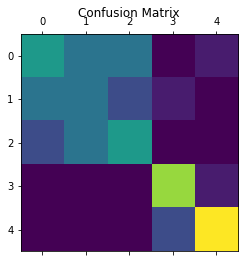

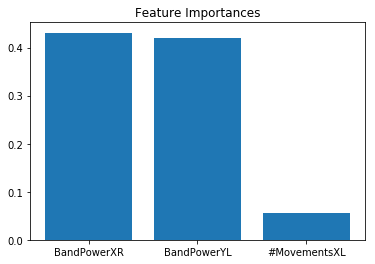

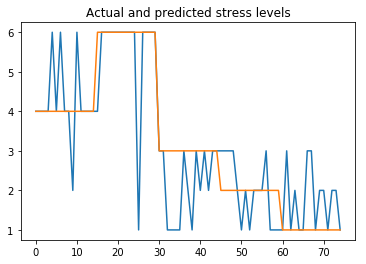

In [112]:
#### Explore machine learning methods
    
## Better machine learning evaluation using cross-validation
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from scipy.stats import pearsonr
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB 
from sklearn.linear_model import LinearRegression

## Evaluate using accuracy
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix


est=GradientBoostingClassifier()

# Classify data in 10-fold cross validation and display resulting accuracy
prediction = cross_val_predict(est, aligned[['BandPowerXR','BandPowerYL', '#MovementsXL']].values, aligned['stress'].values.astype(int), cv=14)
acc = accuracy_score(prediction,aligned['stress'].values.astype(int) )
print('Accuracy in 10-fold cross-valdiation is %f' % acc)


# To get more insights were the errors are happening
confusions = confusion_matrix(prediction, aligned['stress'].values.astype(int))
fig, ax = plt.subplots()
ax.matshow(confusions)
plt.title('Confusion Matrix')

#Try to analyse classifier
fig, ax = plt.subplots()
est.fit(aligned[['BandPowerXR','BandPowerYL', '#MovementsXL']].values, aligned['stress'].values.astype(int))
ax.bar(np.arange(3),est.feature_importances_)
plt.xticks(np.arange(3),['BandPowerXR','BandPowerYL', '#MovementsXL'])
plt.title('Feature Importances')


fig,ax = plt.subplots()
plt.plot(prediction)
plt.plot(aligned['stress'].values)
plt.title('Actual and predicted stress levels')

Correlation (r) and p-value of Linear Regression is 0.777 and 0.0
Correlation (r) and p-value of Gradient Boosting Regression is 0.814 and 0.0


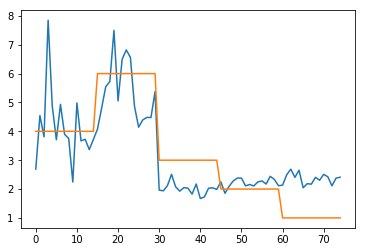

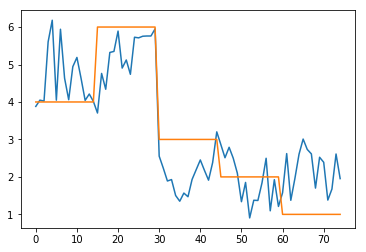

In [111]:
# analyzing multiple (regression) methods with a loop 

estLoop=[LinearRegression(),GradientBoostingRegressor()]
estNames=["Linear Regression","Gradient Boosting Regression"]

for i,j in zip(estLoop,estNames):
    prediction = cross_val_predict(i, aligned[['BandPowerXR','BandPowerYL', '#MovementsXL']].values, aligned['stress'].values.astype(int), cv=14)
    r, p = pearsonr(prediction, aligned['stress'].values)
    print(('Correlation (r) and p-value of %s is' % j), round(r,3), 'and', round(p,3))
    
    fig, ax = plt.subplots() #create subplots, otherwise everything is plotted in 1 figure
    plt.plot(prediction)
    plt.plot(aligned['stress'].values)

(75, 3)
(75,)


Text(0.5,1,'Actual and predicted stress levels')

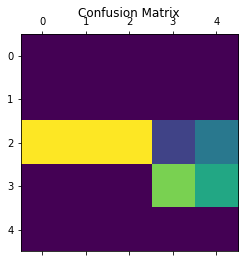

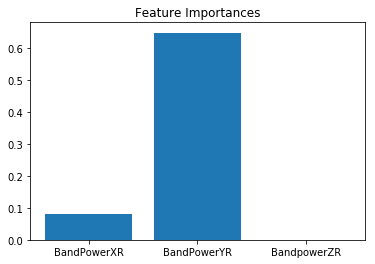

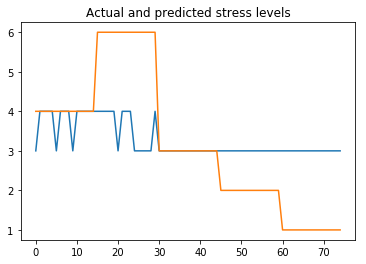

In [126]:
# test prediction of classes of esmTremor, based on continuous sensor tremor data: bandPower

model = GaussianNB() # instantiate model

# input, training data = mean BandPowers of left side
trainLabels = ['BandPowerXL','BandPowerYL','BandPowerZL']

xTrain = aligned[trainLabels].values # take values to make sure only values are considered, check with .shape
print(xTrain.shape)

# training output = esmTremor: 'tremor'
yTrain = aligned['tremor'].values.astype(int) # since output is classificated, must be INTEGERS! .astype(int)
print(yTrain.shape)

# fitting model
model.fit(xTrain, yTrain)

# to test model, we use sensor data other side as input (xTest)
testLabels = ['BandPowerXR','BandPowerYR','BandPowerZR']
xTest = aligned[testLabels].values
yTest = model.predict(xTest) 

# To get more insights were the errors are happening
confusions = confusion_matrix(yTest, aligned['stress'].values.astype(int))
fig, ax = plt.subplots()
ax.matshow(confusions)
plt.title('Confusion Matrix')

#Try to analyse classifier
fig, ax = plt.subplots()
est.fit(xTest, yTest)
ax.bar(np.arange(3),est.feature_importances_)
plt.xticks(np.arange(3),['BandPowerXR','BandPowerYR', 'BandpowerZR'])
plt.title('Feature Importances')

# visualize tested model
fig,ax = plt.subplots()
plt.plot(yTest)
plt.plot(aligned['stress'].values)
plt.title('Actual and predicted stress levels') # x-as waardes moeten gecorrigeerd worden